**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2022</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: DEC 23, 2022 23:59 (GMT+3)</center></h4>

In this third homework assignment, you are asked to develop a system that can be used to supply additional information to weather forecasts. For this task, you are provided a dataset that consists of weather images that belong to four different weather conditions: [cloudy, rain, shiny, sunrise]. Your model will classify images considering these class labels. 

For this assignment, **using PyTorch is mandatory.**

**Tip:** You may experience latencies in file I/O if you are using Google Colab. In this regard, we recommend you upload your data to Google Drive as a zip file and unzip the folder contents in your drive. If you would like to upload the data files separately, it may take significant time.

You will submit a single ipynb file as the homework submission. If you want to provide further explanation about your work, you can add Markdown cells to do so. [Here](https://www.markdownguide.org/), you can find a guide for Markdown syntax. Upload your homework with the following filename convention: \<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb

**Dataset**<br>
You can find the dataset [here](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset). 


# **Q1** [12 points]
This part consists of 4 questions which you are expected to answer. Please fill in the following cell in Markdown format. Each question is worth 2 points.

a) Do we need to output the actual probability values when performing classification with the softmax layer? If not, how do these numbers represent the likelihood of classes? Also, does the output values should be in a specific range for us to make a classification? <br>
You do not need to output the actual probability values in a classification task. t is sufficient to simply predict the class with the highest probability as the final prediction.
 The output values can be thought as the predicted probability of each class for the given data.
No, since what we care is the highest value.
b) From the perspective of model complexity, how you can identify when a model underfits or overfits? Which plots are informative for detecting this behavior? <br>
If training data has a big error it underfits. If training data has a low error but validation data has a big error it overfits. So the error plots of validation and training errors are helpful for detecting underfitting or overfitting.
c) In neural networks, how does the ReLU function help us to generalize to complex feature spaces? Why we are not using linear layers only? <br>
Linear functions can only learn linear relationships. However, ReLu is a nonlinear function, so it can represent nonlinear feature spaces. That's why ReLu is used for complex feature spaces.
d) Assume that you are going to pass the feature matrix with dimensions 64x64x5 (Height x Width x Channel size) through a convolutional layer. If our convolutional layer has a kernel size of 3x3 and the number of filters is 6, how many learnable parameters are present? <br>
6x((3x3x5)+1) = 276

# **Q2** [88 points]

## Necessary Imports
In the cell below, we import some utilities that you can make use of in this assignment. Note that you need to use PyTorch in this assignment. To report certain metrics (like precision, recall, accuracy) you may use utilities from *scikit-learn* library. You can edit these imports considering your implementation as long as you use PyTorch.

## Setup

In [2]:
import os
import time
import random

import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

You can test whether hardware acceleration with GPU is enabled in the cell below. In addition, if you have GPU access, you can check the amount of available GPU memory.

In [3]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory / 1024 ** 3, 1), 'GB')

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3070 Laptop GPU
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     8.0 GB


**DO NOT CHANGE**<br>
To evaluate your implementation fairly, we set seed values for random sampling methods in PyTorch, Numpy, and Python random library. These seeds are set to evaluate your models successfully, so do not change these values.

In [4]:
# for reproducable results
torch.manual_seed(464)
torch.cuda.manual_seed(464)
np.random.seed(464)
random.seed(464)
if device.type == 'cuda':
    torch.backends.cudnn.deterministic = True

## Load Data [6 points]
In this assignment, you will use a custom dataset, which you need a wrapper class to access its data. For this purpose, implement a custom dataset class to organize data with the specifications you need. This class will load batches of data using a PyTorch DataLoader later. The class signature of CustomDataset class is provided to you in the cell below, where you can implement your custom dataset.

**IMPORTANT:** As you may have difficulties while fitting all images to your RAM, you need to read the images while getting that item (each item is an image here). We encourage you to read the data files in the "__getitem__" function to avoid encountering any issues related to fitting the data to memory. This way, you do not need to hold the dataset in a single variable, which would be memory intensive.

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, **kwargs):
        self.transform = kwargs.get("transform")
        if self.transform:
            self.data = [self.transform(x) for x in data]
        else:
            self.data = data
        self.labels = labels

    '''This function should return sample count in the dataset'''

    def __len__(self):
        return len(self.labels)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

You can implement an additional function to read and construct custom dataset objects for training, validation, and test sets. While constructing the dataset, consider the following issues:
- Dataset contains images that end with prefixes *.jpg* and *.jpeg*.
- If you use PIL to read images, you should convert them to "RGB" format to operate on three color channels.
- Resize the dataset images to 224x224. You are going to design models that take images with tensor shape 224x224x3.
- If you wish, you can change the ordering of the color channels with np.moveaxis function

Lastly, the train-validation-test split for the dataset provided to you is 70-10-20 in terms of percentages. While constructing the dataset, remember that shuffling is a necessary step (to get randomly distributed classes across batches).

You can design your dataset getter method compatible with the line provided below, where train_dataset, val_dataset, and test_dataset are all instances of CustomDataset.

In [6]:
image_list = []
labels = []
label_texts = ["Cloudy", "Rain", "Shine", "Sunrise"]
transform_with_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
tensor_to_image = transforms.Compose([transforms.ToPILImage()])
idx = 0
for i in range(4):
    for filename in glob.glob(f'D:/Code/python/cs464hw3/data/{label_texts[i]}/*.jpg'):
        img = Image.open(filename).convert("RGB")
        resized = transform_with_resize(img)
        #img_from_tensor = tensor_to_image(resized)
        cn_image = (resized - resized.min()) / (resized.max() - resized.min())
        image_list.append(cn_image)
        # l = np.zeros(4, dtype=np.float32)
        # l[i] = 1
        labels.append(torch.tensor(i))

train_data, test_data, train_label, test_label = train_test_split(image_list, labels, test_size=0.3, shuffle=True,
                                                                  random_state=42)
val_data, test_data, val_label, test_label = train_test_split(test_data, test_label, test_size=0.6666, shuffle=True,
                                                              random_state=42)
train_dataset = CustomDataset(train_data, train_label)
test_dataset = CustomDataset(test_data, test_label)
val_dataset = CustomDataset(val_data, val_label)

## Models [16 points]
In this assignment, you will implement one CNN (Convolutional Neural Network) model and one FCN (Fully-Connected Network) model, where the class signatures are provided below.

### Convolutional Neural Network (CNN) Model [8 points]
As the first model, you will implement a convolutional model. Your model will include 3 CONV + POOL blocks, which denotes one Convolutional layer followed by a Max Pooling Layer. The channel sizes for convolutional blocks are [16, 32, 64], respectively. For all convolutional layers, take kernel size as 3, stride as one, and apply padding such that convolutions do not change the shape on width and height dimensions. 
<br><br>
Following the convolutional part, you will perform image classification for the dataset provided to you. You can use ReLU activation as the non-linearity in your model (except the classification layer).

In [7]:
class ConvNet(nn.Module):
    """Define your convolutional neural network"""

    def __init__(self, **kwargs):
        super(ConvNet, self).__init__()
        self.conv_channels = [16, 32, 64]
        self.model = nn.Sequential(
            nn.Conv2d(3, self.conv_channels[0], stride=1, kernel_size=3, padding="same"),
            nn.BatchNorm2d(self.conv_channels[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(self.conv_channels[0], self.conv_channels[1], stride=1, kernel_size=3, padding="same"),
            nn.BatchNorm2d(self.conv_channels[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(self.conv_channels[1], self.conv_channels[2], stride=1, kernel_size=3, padding="same"),
            nn.BatchNorm2d(self.conv_channels[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.output_size = 224 // 8
        self.lModel = nn.Sequential(
            nn.Linear(in_features=self.conv_channels[2] * self.output_size * self.output_size,
                      out_features=self.conv_channels[2]),
            nn.Linear(in_features=self.conv_channels[2], out_features=self.conv_channels[1]),
            nn.Linear(in_features=self.conv_channels[1], out_features=self.conv_channels[0]),
            nn.Linear(in_features=self.conv_channels[0], out_features=4)
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, self.conv_channels[2] * self.output_size * self.output_size)
        x = self.lModel(x)
        return x

### Fully Connected Network (FCN) Model [8 points]
The second model you will try is a Fully Connected Network composed of Linear layers and non-linear activation functions connected to each other. For this part, the number of features for your linear layers is [1024, 512, 256]. Again, you can use ReLU as your non-linear activation function in your model (except the classification layer).

In [8]:
'''Define your full connected network'''


class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(3 * 224 * 224, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        x = nn.ReLU()(x)
        x = self.fc4(x)
        return x

## Training and Evaluation of FCN [22 points]

Now that you implemented the model definition of CNN and FCN, you will train these models with the hyperparameters you chose. The hyperparameters that you may change are listed in the cell below. Using the FCN model defined, train a classifier that predicts weather condition classes specified by the dataset. For the optimizer, use [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer provided by PyTorch. You should try out different hyper-parameters like learning rates, epochs, momentum, and weight decay. For [momentum](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/) and [weight decay](https://paperswithcode.com/method/weight-decay), you can read about these concepts if you are interested.

While training your model, save your best model over different epochs. You must select an appropriate metric to define the best model at a time step. You can implement the training procedure in the cell below. If you want to explain the reasoning behind your metric selection, you can add a markdown cell and provide your comments.

### Training [12 points]

In [17]:
#HINT: note that your training time should not take many days.
criterion = nn.CrossEntropyLoss()
model = FCNet()
if device.type == 'cuda':
    model.cuda()
#Pick your hyper parameters
max_epoch = 100
train_batch = 64
test_batch = 64
learning_rate = 1.6e-2
momentum = 0.7
weight_decay = 5e-04

# TODO: training loop + eval
train_data_loader = DataLoader(train_dataset, batch_size=train_batch)
val_data_loader = DataLoader(val_dataset, batch_size=train_batch)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
no_of_epochs = 30
iter_losses = []
epoch_losses = []
accuracies = []
val_accuracies = []
val_epoch_losses = []
model.train()
for epoch in range(no_of_epochs):
    running_loss = 0.0
    print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
    accuracies.append(0.)
    val_accuracies.append(0.)
    for batch_data, batch_labels in tqdm(train_data_loader):
        batch_data = batch_data.reshape(len(batch_labels), 224 * 224 * 3)
        optimizer.zero_grad()  # Setting the starting gradients as 0
        batch_outputs = model(batch_data.cuda())  # Predict outputs
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda())  # Calculate the loss
        loss.backward()  # Calculate the gradients
        optimizer.step()  # Update the weights
        # iter_losses.append(loss.item())
        for i in range(len(batch_labels)):
            if torch.argmax(batch_outputs[i]) == batch_labels[i]:
                accuracies[epoch] += 1
        running_loss += loss.item()
    accuracies[epoch] /= len(train_data_loader) * train_batch
    epoch_losses.append(running_loss / len(train_data_loader))
    print("Loss for epoch: {}".format(running_loss / len(train_data_loader)))
    val_running_loss = 0.0
    model.eval()
    for batch_data, batch_labels in tqdm(val_data_loader):
        batch_data = batch_data.reshape(len(batch_labels), 224 * 224 * 3)
        batch_outputs = model(batch_data.cuda())
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda())
        for i in range(len(batch_labels)):
            if torch.argmax(batch_outputs[i]) == batch_labels[i]:
                val_accuracies[epoch] += 1
        # iter_losses.append(loss.item())
        val_running_loss += loss.item()
    val_accuracies[epoch] /= len(val_data_loader) * test_batch
    val_epoch_losses.append(val_running_loss / len(val_data_loader))
print("Finished training and eval")

Epoch: 1/30


100%|██████████| 13/13 [00:00<00:00, 15.61it/s]


Loss for epoch: 1.1454810821093047


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch: 2/30


100%|██████████| 13/13 [00:00<00:00, 15.75it/s]


Loss for epoch: 0.8302745177195623


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch: 3/30


100%|██████████| 13/13 [00:00<00:00, 15.53it/s]


Loss for epoch: 0.9766933505351727


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch: 4/30


100%|██████████| 13/13 [00:00<00:00, 15.54it/s]


Loss for epoch: 0.7475797304740319


100%|██████████| 2/2 [00:00<00:00, 27.25it/s]


Epoch: 5/30


100%|██████████| 13/13 [00:00<00:00, 15.59it/s]


Loss for epoch: 0.6851240832072037


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch: 6/30


100%|██████████| 13/13 [00:00<00:00, 15.55it/s]


Loss for epoch: 0.6477306691499857


100%|██████████| 2/2 [00:00<00:00, 28.98it/s]


Epoch: 7/30


100%|██████████| 13/13 [00:00<00:00, 15.57it/s]


Loss for epoch: 0.6164114268926474


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch: 8/30


100%|██████████| 13/13 [00:00<00:00, 15.37it/s]


Loss for epoch: 0.6072565798576062


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch: 9/30


100%|██████████| 13/13 [00:00<00:00, 15.68it/s]


Loss for epoch: 0.5500524892256811


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch: 10/30


100%|██████████| 13/13 [00:00<00:00, 15.17it/s]


Loss for epoch: 0.5084316959747901


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch: 11/30


100%|██████████| 13/13 [00:00<00:00, 15.40it/s]


Loss for epoch: 0.5148571385787084


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch: 12/30


100%|██████████| 13/13 [00:00<00:00, 15.57it/s]


Loss for epoch: 0.5090231895446777


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch: 13/30


100%|██████████| 13/13 [00:00<00:00, 15.61it/s]


Loss for epoch: 0.5039065228058741


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch: 14/30


100%|██████████| 13/13 [00:00<00:00, 15.46it/s]


Loss for epoch: 0.47032057780485886


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch: 15/30


100%|██████████| 13/13 [00:00<00:00, 15.12it/s]


Loss for epoch: 0.43767611338542056


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch: 16/30


100%|██████████| 13/13 [00:00<00:00, 15.55it/s]


Loss for epoch: 0.41770918094194853


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch: 17/30


100%|██████████| 13/13 [00:00<00:00, 15.61it/s]


Loss for epoch: 0.40182244777679443


100%|██████████| 2/2 [00:00<00:00, 30.30it/s]


Epoch: 18/30


100%|██████████| 13/13 [00:00<00:00, 15.33it/s]


Loss for epoch: 0.3889121940502754


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch: 19/30


100%|██████████| 13/13 [00:00<00:00, 15.20it/s]


Loss for epoch: 0.380556651032888


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch: 20/30


100%|██████████| 13/13 [00:00<00:00, 15.53it/s]


Loss for epoch: 0.3611145386329064


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch: 21/30


100%|██████████| 13/13 [00:00<00:00, 15.46it/s]


Loss for epoch: 0.3482610560380496


100%|██████████| 2/2 [00:00<00:00, 28.97it/s]


Epoch: 22/30


100%|██████████| 13/13 [00:00<00:00, 15.57it/s]


Loss for epoch: 0.33306550750365627


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch: 23/30


100%|██████████| 13/13 [00:00<00:00, 15.38it/s]


Loss for epoch: 0.31650435007535493


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch: 24/30


100%|██████████| 13/13 [00:00<00:00, 15.22it/s]


Loss for epoch: 0.29963596623677474


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch: 25/30


100%|██████████| 13/13 [00:00<00:00, 15.45it/s]


Loss for epoch: 0.37555110913056594


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch: 26/30


100%|██████████| 13/13 [00:00<00:00, 15.12it/s]


Loss for epoch: 0.2960126841297516


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch: 27/30


100%|██████████| 13/13 [00:00<00:00, 15.31it/s]


Loss for epoch: 0.28817883076576084


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch: 28/30


100%|██████████| 13/13 [00:00<00:00, 15.06it/s]


Loss for epoch: 0.3878089372928326


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch: 29/30


100%|██████████| 13/13 [00:00<00:00, 15.49it/s]


Loss for epoch: 0.29899421219642347


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch: 30/30


100%|██████████| 13/13 [00:00<00:00, 15.46it/s]


Loss for epoch: 0.3105902820825577


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]

Finished training and eval


### Learning Process Analysis [5 points]
Following the training step, you will now provide accuracy and loss plots over all epochs. For this, provide two plots:
- In the first plot, you will provide the value of the accuracy metric over epochs. Your plot should include two curves, one for the training set and the other for the validation set.
- For the second plot, provide the curve for loss values over epochs. Again your plot should include two curves, where one indicates loss on the training set and the second indicates loss for the validation set.

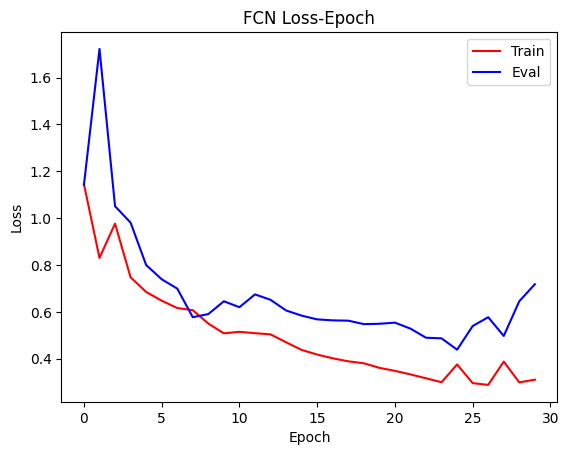

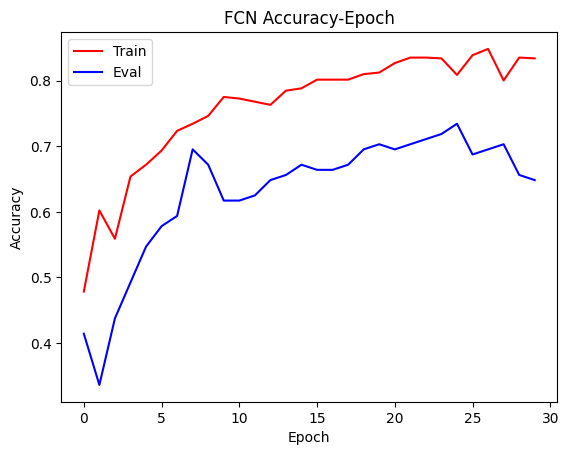

In [18]:
def plot(title):
    plt.plot(epoch_losses, color='red', label='Train')
    plt.plot(val_epoch_losses, color='blue', label='Eval')
    plt.title(title + ' Loss-Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.plot(accuracies, color='red', label='Train')
    plt.plot(val_accuracies, color='blue', label='Eval')
    plt.title(title + ' Accuracy-Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


plot("FCN")

### Test [5 points]
As the final step of your analysis, you will test your model using some metrics. For the best model you obtained during training, evaluate your model on the test set. Then, report the confusion matrix. Finally, report accuracy, precision, recall, and $F_1$ score using your model. Report all these metrics using the macro form (macro precision, macro recall, etc.). You can implement these metrics in the cell below. 

100%|██████████| 225/225 [00:00<00:00, 226.68it/s]


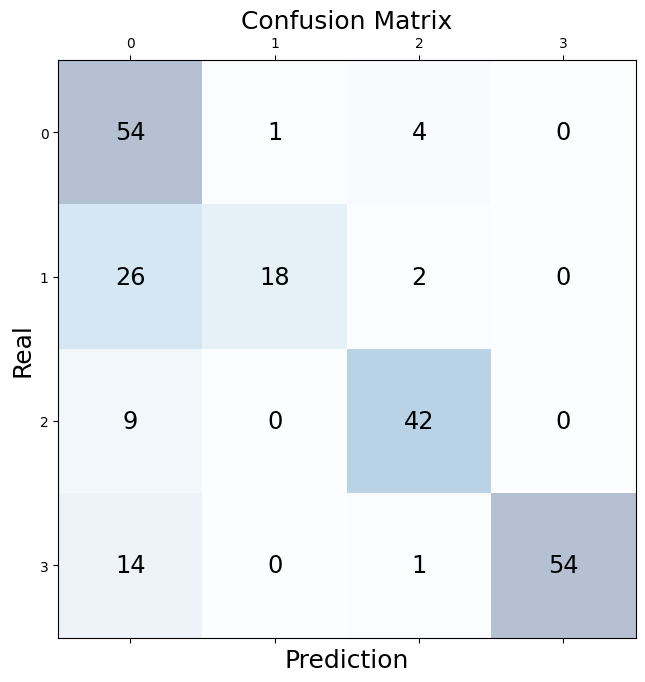

f1: 0.7346404002501563
precision: 0.8321957807139208
recall: 0.7281741731327755
accuracy: 0.7466666666666667


In [19]:
def print_data(data_loader, label, is_fcn=False):
    model.eval()
    predicts = []
    for data, labels in tqdm(data_loader):
        if is_fcn:
            data = data.reshape(1, 224 * 224 * 3)
        outputs = model(data.cuda())
        predicts.append(torch.argmax(outputs).cpu())
    t_label = [el.item() for el in label]
    conf_matrix = confusion_matrix(y_true=t_label, y_pred=predicts)
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Prediction', fontsize=18)
    plt.ylabel('Real', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    print(f"f1: {f1_score(t_label, predicts, average='macro')}")
    print(f"precision: {precision_score(t_label, predicts, average='macro')}")
    print(f"recall: {recall_score(t_label, predicts, average='macro')}")
    print(f"accuracy: {accuracy_score(t_label, predicts)}")


test_data_loader = DataLoader(test_dataset)
print_data(test_data_loader, test_label, True)

## Training and evaluation of CNN [22 points]
Similar to the FCN model, you will now train the CNN model that you defined before. Again you are free to try out different hyperparameters. This model also will classify weather images with the four classes provided by the dataset. As the optimizer, again, use the SGD implementation provided by PyTorch. You can implement the training loop in the following cell. 

Similar to the training procedure, you need to save the best model you obtain during training. Select an appropriate criterion (metric) to save the best model. If you wish, you can add a markdown cell to explain your reasoning.

### Training [12 points]

In [35]:
criterion = nn.CrossEntropyLoss()
model = ConvNet()
if device.type == 'cuda':
    model.cuda()
max_epoch = 100
train_batch = 64
test_batch = 64
learning_rate = 1e-2
momentum = 0.7
weight_decay = 5e-03

# TODO: training loop + eval
train_data_loader = DataLoader(train_dataset, batch_size=train_batch)
val_data_loader = DataLoader(val_dataset, batch_size=train_batch)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
no_of_epochs = 20
iter_losses = []
epoch_losses = []
accuracies = []
val_accuracies = []
val_epoch_losses = []
for epoch in range(no_of_epochs):
    running_loss = 0.0
    print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
    accuracies.append(0.)
    val_accuracies.append(0.)
    model.train()
    for batch_data, batch_labels in tqdm(train_data_loader):
        optimizer.zero_grad()  # Setting the starting gradients as 0
        batch_outputs = model(batch_data.cuda())  # Predict outputs
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda())  # Calculate the loss
        loss.backward()  # Calculate the gradients
        optimizer.step()  # Update the weights
        # iter_losses.append(loss.item())
        for i in range(len(batch_labels)):
            if torch.argmax(batch_outputs[i]) == batch_labels[i]:
                accuracies[epoch] += 1
        running_loss += loss.item()
    accuracies[epoch] /= len(train_data_loader) * train_batch
    epoch_losses.append(running_loss / len(train_data_loader))
    print("Loss for epoch: {}".format(running_loss / len(train_data_loader)))
    val_running_loss = 0.0
    model.eval()
    for batch_data, batch_labels in tqdm(val_data_loader):
        batch_outputs = model(batch_data.cuda())
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda())
        for i in range(len(batch_labels)):
            if torch.argmax(batch_outputs[i]) == batch_labels[i]:
                val_accuracies[epoch] += 1
        # iter_losses.append(loss.item())
        val_running_loss += loss.item()
    val_accuracies[epoch] /= len(val_data_loader) * test_batch
    val_epoch_losses.append(val_running_loss / len(val_data_loader))
print("Finished training and eval")

Epoch: 1/20


100%|██████████| 13/13 [00:01<00:00, 10.13it/s]


Loss for epoch: 0.6638401861374195


100%|██████████| 2/2 [00:00<00:00, 21.50it/s]


Epoch: 2/20


100%|██████████| 13/13 [00:00<00:00, 13.18it/s]


Loss for epoch: 0.402090673836378


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch: 3/20


100%|██████████| 13/13 [00:00<00:00, 13.18it/s]


Loss for epoch: 0.2666486450112783


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch: 4/20


100%|██████████| 13/13 [00:00<00:00, 13.17it/s]


Loss for epoch: 0.2050850517474688


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch: 5/20


100%|██████████| 13/13 [00:00<00:00, 13.28it/s]


Loss for epoch: 0.16506401736002702


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch: 6/20


100%|██████████| 13/13 [00:00<00:00, 13.39it/s]


Loss for epoch: 0.12484447400157268


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch: 7/20


100%|██████████| 13/13 [00:00<00:00, 13.25it/s]


Loss for epoch: 0.09612398995802952


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch: 8/20


100%|██████████| 13/13 [00:00<00:00, 13.03it/s]


Loss for epoch: 0.07882731207288228


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch: 9/20


100%|██████████| 13/13 [00:01<00:00, 12.96it/s]


Loss for epoch: 0.06159848512078707


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch: 10/20


100%|██████████| 13/13 [00:01<00:00, 12.99it/s]


Loss for epoch: 0.04936305909919051


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch: 11/20


100%|██████████| 13/13 [00:01<00:00, 12.36it/s]


Loss for epoch: 0.03790542701832377


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch: 12/20


100%|██████████| 13/13 [00:01<00:00, 12.69it/s]


Loss for epoch: 0.02780811585342655


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch: 13/20


100%|██████████| 13/13 [00:01<00:00, 12.92it/s]


Loss for epoch: 0.0202108640402842


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch: 14/20


100%|██████████| 13/13 [00:00<00:00, 13.11it/s]


Loss for epoch: 0.016648323060228273


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch: 15/20


100%|██████████| 13/13 [00:00<00:00, 13.09it/s]


Loss for epoch: 0.014701100478235345


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch: 16/20


100%|██████████| 13/13 [00:00<00:00, 13.13it/s]


Loss for epoch: 0.014043872450621655


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch: 17/20


100%|██████████| 13/13 [00:00<00:00, 13.29it/s]


Loss for epoch: 0.013438954412077483


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch: 18/20


100%|██████████| 13/13 [00:00<00:00, 13.14it/s]


Loss for epoch: 0.012041905590404686


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch: 19/20


100%|██████████| 13/13 [00:00<00:00, 13.25it/s]


Loss for epoch: 0.012041648643879363


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch: 20/20


100%|██████████| 13/13 [00:00<00:00, 13.28it/s]


Loss for epoch: 0.010494570256783985


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]

Finished training and eval


### Learning Process Analysis [3 points]
Repeating the same procedure you applied for the FCN model; you will provide two plots about how your training proceeds over epochs. Again, provide two plots: one summarizes the loss values, and the other summarizes the accuracy values. Note that each plot needs to include two curves, one for the validation set and the other for the training set.

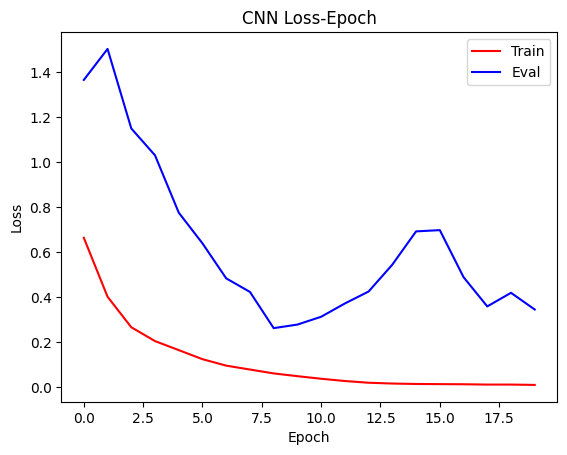

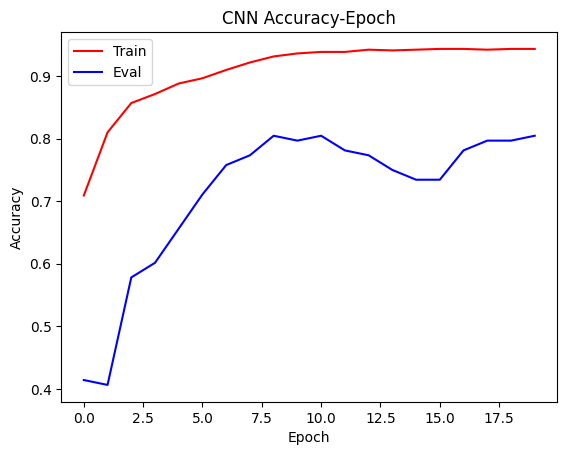

In [36]:
plot("CNN")

### Test [4 points]
Concluding your analysis, report the confusion matrix for the best model you obtained during your CNN model training. Then using this confusion matrix, report accuracy, recall, precision, and $F_1$ score for your best model. Use macro averaging in all of your metrics.

100%|██████████| 225/225 [00:01<00:00, 186.73it/s]


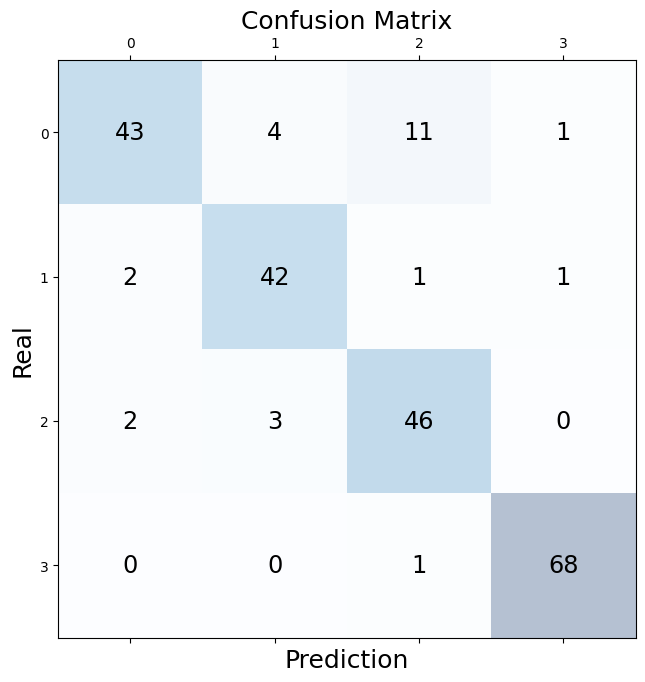

f1: 0.8775780458958644
precision: 0.8807815156354645
recall: 0.8823312670683601
accuracy: 0.8844444444444445


In [37]:
test_data_loader = DataLoader(test_dataset)
print_data(test_data_loader, test_label)

### Discussion [3 points]
Now, try to compare the two models that you trained. How different are these two models regarding the number of parameters used?
CNN:(9 * 3 + 1) * 16 + (9 * 16 + 1) * 32 + (9 * 32 + 1) * 64 + (28 * 28 * 64 + 1) * 32 + (32 + 1) * 16 + (16 + 1) * 4 = 1629,844
FCN:(3 * 224 * 224 + 1) * 1024 + (1024 + 1) * 512 + (512 + 1) * 256 + (256 + 1) * 4 = 154,798,852
Explain your findings by connecting them with your experimental results. You can include your comments on a separate Markdown cell or below the question statement.

Although FCN contains more parameters, CNN's convolutional layers allow the model to represent more complex structures.
Hence, it performs better.

## Transfer Learning [22 points]

As the last part of this assignment, you will practice transfer learning. In this methodology, we aim to use models trained on large-scale datasets for our task. As we do not have access to large datasets and computational resources all the time, we sometimes try to use already trained models (on other datasets) as a good starting point for our model, and then fine-tune the weights considering our task.  

Torchvision library provides numerous models pretrained for specific tasks. [Here](https://pytorch.org/vision/stable/models.html), you can find a list of pretrained models. For this part, you will include [ResNet](https://arxiv.org/abs/1512.03385)-18 model, pretrained with ImageNet dataset. ImageNet is a large dataset where training from scratch would take a long time. You will fine-tune this pretrained module for your task. 
<br>
**Hint:** You can add a Linear layer to adapt the model to the number of classes needed for your task. You can access the number of inputs to the ResNet-18 model as $\texttt{model.fc.in_features}$ and then modify the fully connected layer of the model $\texttt{model.fc}$.
<br>

Using the ResNet-18 backbone, implement this model's training loop (by adapting it to your task). You can implement the training procedure in the cell provided below. Again save your model based on a criterion indicating the best model. Explain the reasoning for your criteria. Use the SGD optimizer provided by PyTorch to optimize your model.

Just like the previous parts, you can also tune your hyperparameters to optimize your model's performance. 

###Training [12 points]

In [81]:
from torchvision.models import ResNet18_Weights
from torchvision.models import resnet18
max_epoch = 10
train_batch = 64
test_batch = 64
learning_rate = 6e-3
weight_decay = 5e-04
# Step 1: Initialize model with the best available weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.cuda()
model.fc.out_features = 4
model.train()
criterion = nn.CrossEntropyLoss()
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()
# Step 3: Apply inference preprocessing transforms
train_dataset_l = CustomDataset(train_data, train_label, transform=preprocess)
val_dataset_l = CustomDataset(val_data, val_label, transform=preprocess)
train_data_loader = DataLoader(train_dataset_l, batch_size=train_batch)
val_data_loader = DataLoader(val_dataset_l, batch_size=train_batch)
optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
no_of_epochs = 20
iter_losses = []
epoch_losses = []
accuracies = []
val_epoch_losses = []
val_accuracies = []

for epoch in range(no_of_epochs):
    running_loss = 0.0
    print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
    accuracies.append(0.)
    val_accuracies.append(0.)
    model.train()
    for batch_data, batch_labels in tqdm(train_data_loader):
        optimizer.zero_grad()  # Setting the starting gradients as 0
        batch_outputs = model(batch_data.cuda())  # Predict outputs
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda())  # Calculate the loss
        loss.backward()  # Calculate the gradients
        optimizer.step()  # Update the weights
        # iter_losses.append(loss.item())
        for i in range(len(batch_labels)):
            if torch.argmax(batch_outputs[i]) == batch_labels[i]:
                accuracies[epoch] += 1
        running_loss += loss.item()
    accuracies[epoch] /= len(train_data_loader) * train_batch
    epoch_losses.append(running_loss / len(train_data_loader))
    print("Loss for epoch: {}".format(running_loss / len(train_data_loader)))
    val_running_loss = 0.0
    model.eval()
    for batch_data, batch_labels in tqdm(val_data_loader):
        batch_outputs = model(batch_data.cuda())
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda())
        for i in range(len(batch_labels)):
            if torch.argmax(batch_outputs[i]) == batch_labels[i]:
                val_accuracies[epoch] += 1
        val_running_loss += loss.item()
    val_accuracies[epoch] /= len(val_data_loader) * test_batch
    val_epoch_losses.append(val_running_loss / len(val_data_loader))
print("Finished training and eval")

Epoch: 1/20


100%|██████████| 13/13 [00:02<00:00,  5.99it/s]


Loss for epoch: 4.834144665644719


100%|██████████| 2/2 [00:00<00:00, 16.67it/s]


Epoch: 2/20


100%|██████████| 13/13 [00:01<00:00,  7.16it/s]


Loss for epoch: 1.0874283451300402


100%|██████████| 2/2 [00:00<00:00, 16.39it/s]


Epoch: 3/20


100%|██████████| 13/13 [00:01<00:00,  7.18it/s]


Loss for epoch: 0.6281279073311732


100%|██████████| 2/2 [00:00<00:00, 15.87it/s]


Epoch: 4/20


100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Loss for epoch: 0.45498748696767366


100%|██████████| 2/2 [00:00<00:00, 16.26it/s]


Epoch: 5/20


100%|██████████| 13/13 [00:01<00:00,  7.16it/s]


Loss for epoch: 0.3678020009627709


100%|██████████| 2/2 [00:00<00:00, 16.13it/s]


Epoch: 6/20


100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Loss for epoch: 0.31430524243758273


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch: 7/20


100%|██████████| 13/13 [00:01<00:00,  6.98it/s]


Loss for epoch: 0.27713289169164806


100%|██████████| 2/2 [00:00<00:00, 15.38it/s]


Epoch: 8/20


100%|██████████| 13/13 [00:01<00:00,  7.10it/s]


Loss for epoch: 0.2495320548231785


100%|██████████| 2/2 [00:00<00:00, 15.87it/s]


Epoch: 9/20


100%|██████████| 13/13 [00:01<00:00,  6.99it/s]


Loss for epoch: 0.22822673102984062


100%|██████████| 2/2 [00:00<00:00, 16.13it/s]


Epoch: 10/20


100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Loss for epoch: 0.2112361043691635


100%|██████████| 2/2 [00:00<00:00, 16.26it/s]


Epoch: 11/20


100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Loss for epoch: 0.1972779929637909


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch: 12/20


100%|██████████| 13/13 [00:01<00:00,  6.99it/s]


Loss for epoch: 0.18552270187781408


100%|██████████| 2/2 [00:00<00:00, 15.75it/s]


Epoch: 13/20


100%|██████████| 13/13 [00:01<00:00,  7.10it/s]


Loss for epoch: 0.1754246480189837


100%|██████████| 2/2 [00:00<00:00, 16.13it/s]


Epoch: 14/20


100%|██████████| 13/13 [00:01<00:00,  6.95it/s]


Loss for epoch: 0.16661200729700235


100%|██████████| 2/2 [00:00<00:00, 15.45it/s]


Epoch: 15/20


100%|██████████| 13/13 [00:01<00:00,  6.98it/s]


Loss for epoch: 0.15882206650880668


100%|██████████| 2/2 [00:00<00:00, 15.04it/s]


Epoch: 16/20


100%|██████████| 13/13 [00:01<00:00,  6.91it/s]


Loss for epoch: 0.15186329701772103


100%|██████████| 2/2 [00:00<00:00, 15.27it/s]


Epoch: 17/20


100%|██████████| 13/13 [00:01<00:00,  6.92it/s]


Loss for epoch: 0.1455921854537267


100%|██████████| 2/2 [00:00<00:00, 14.93it/s]


Epoch: 18/20


100%|██████████| 13/13 [00:01<00:00,  7.02it/s]


Loss for epoch: 0.13989851709741813


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch: 19/20


100%|██████████| 13/13 [00:01<00:00,  7.02it/s]


Loss for epoch: 0.13469633947198206


100%|██████████| 2/2 [00:00<00:00, 15.50it/s]


Epoch: 20/20


100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


Loss for epoch: 0.1299169513468559


100%|██████████| 2/2 [00:00<00:00, 15.87it/s]

Finished training and eval


###Learning Process Analysis [3 points]
After training your model, provide two plots summarizing the learning procedure. Like previous parts, you will provide plots for loss value and accuracy progression over epochs. Remember that for each plot, you need to include two curves (one for the training set and one for the validation set).

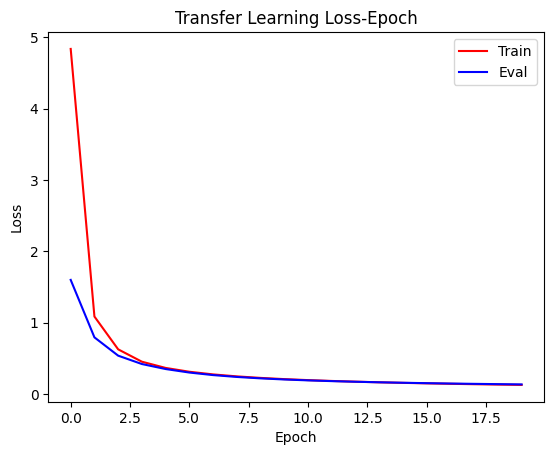

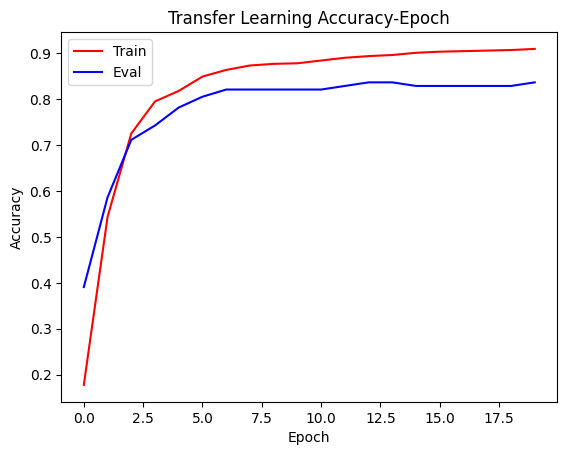

In [82]:
plot("Transfer Learning")

### Test [4 points]
Following your analysis, report the confusion matrix for the best model you obtained (with the criteria you defined). Then, report the accuracy, precision, recall and $F_1$ score for the best model. In all of the metrics, use macro averaging.

100%|██████████| 225/225 [00:03<00:00, 64.10it/s]


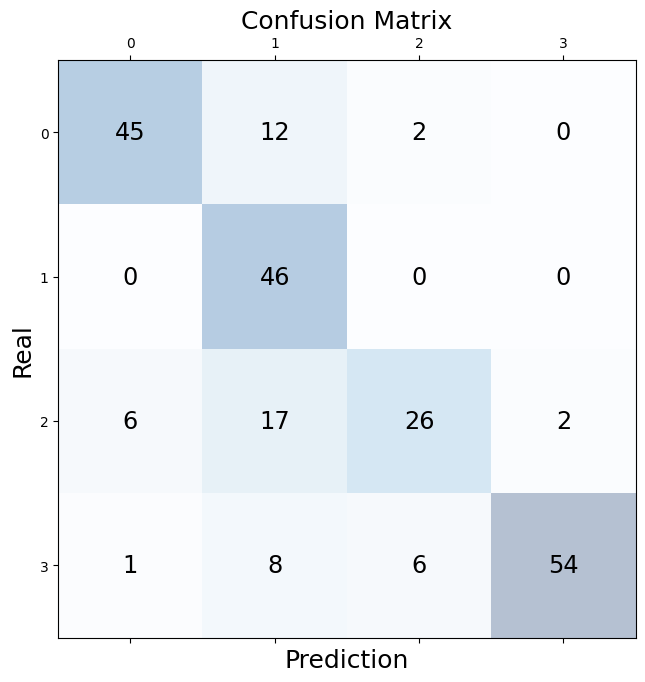

f1: 0.7499384528167018
precision: 0.7871482698732877
recall: 0.7637811204068952
accuracy: 0.76


In [83]:
test_data_loader = DataLoader(test_dataset)
print_data(test_data_loader, test_label)

### Discussion [3 points]
Now discuss the effectiveness of Transfer Learning. How does it improve performance?
It made 0.05 increase in accuracy. Since the weights are already trained, the model tunes its weights better when our data is inserted.

# References
[1] Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1